In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import requests

# Load datasets from Google Drive
pak_id = '1XF94FVGJ2HfInS2jb-JlEUH1JJ2fwupB'
cal_id = '1a9AluzgGh8wrV8eGrHl0dBxMpsMnkZiw'
chi_id = '1Lkp0W-DNPQPr01F2p9WWQH9fXLgNT8pQ'

# Create URLs
pak_url = f'https://drive.google.com/uc?id={pak_id}'
cal_url = f'https://drive.google.com/uc?id={cal_id}'
chi_url = f'https://drive.google.com/uc?id={chi_id}'

# Load datasets
chile = pd.read_csv(chi_url, sep='\t')
cali = pd.read_csv(cal_url, sep='\t')
pak = pd.read_csv(pak_url, sep='\t')

# Merge datasets
eq = pd.concat([chile, cali, pak], ignore_index=True)

# See unique labels and their counts
label_distribution = eq['label'].value_counts()
print("\nLabel distribution:")
print(label_distribution)


# Create label mappings
unique_labels = sorted(eq['label'].unique())
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Convert string labels to indices
eq['label_idx'] = eq['label'].map(label_to_idx)


Label distribution:
label
other_useful_information                             2211
not_related_or_irrelevant                             760
sympathy_and_emotional_support                        690
injured_or_dead_people                                625
caution_and_advice                                    387
donation_needs_or_offers_or_volunteering_services     386
infrastructure_and_utilities_damage                   359
displaced_people_and_evacuations                       79
missing_trapped_or_found_people                        17
Name: count, dtype: int64


In [ ]:
print("\nLabel conversion check:")
print("Original labels first few:", eq['label'].head())
print("Converted labels first few:", eq['label_idx'].head())
print("Unique converted labels:", np.unique(eq['label_idx']))


Label conversion check:
Original labels first few: 0    sympathy_and_emotional_support
1         not_related_or_irrelevant
2         not_related_or_irrelevant
3    sympathy_and_emotional_support
4            injured_or_dead_people
Name: label, dtype: object
Converted labels first few: 0    8
1    6
2    6
3    8
4    4
Name: label_idx, dtype: int64
Unique converted labels: [0 1 2 3 4 5 6 7 8]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
from collections import Counter
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import DistilBertTokenizer, DistilBertModel
import random

def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class CrisisDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

class CrisisBERT(nn.Module):
    def __init__(self, n_classes, dropout_rate=0.3):
        super().__init__()

        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

        # Initialize classifier weights
        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use CLS token
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

def train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs, device):
    best_valid_loss = float('inf')

    # Save first batch for monitoring across epochs
    first_batch = None
    for batch in train_loader:
        first_batch = {k: v.clone() for k, v in batch.items()}
        break

    first_batch = {k: v.to(device) for k, v in first_batch.items()}

    for epoch in range(n_epochs):
        print(f'\nEpoch {epoch+1}/{n_epochs}')

        # Training phase
        model.train()
        total_train_loss = 0
        batch_losses = []

        # Check performance on first batch at start of epoch
        with torch.no_grad():
            first_batch_preds = model(first_batch['input_ids'], first_batch['attention_mask'])
            first_batch_loss = criterion(first_batch_preds, first_batch['label'])
            _, predicted = torch.max(first_batch_preds, 1)
            first_batch_acc = (predicted == first_batch['label']).float().mean()
            print(f"\nFirst batch performance at epoch start:")
            print(f"Loss: {first_batch_loss:.4f}")
            print(f"Accuracy: {first_batch_acc*100:.2f}%")

        progress_bar = tqdm(train_loader, desc='Training')
        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            predictions = model(input_ids, attention_mask)
            loss = criterion(predictions, labels)

            # Monitor predictions every 100 batches
            if batch_idx % 100 == 0:
                with torch.no_grad():
                    pred_probs = F.softmax(predictions, dim=1)
                    print(f"\nBatch {batch_idx}")
                    print(f"Prediction distribution - min: {pred_probs.min():.4f}, max: {pred_probs.max():.4f}")
                    print(f"Mean prediction per class: {pred_probs.mean(dim=0).cpu().numpy()}")

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            batch_losses.append(loss.item())
            total_train_loss += loss.item()

            # Show recent loss trend
            recent_loss = sum(batch_losses[-10:]) / min(len(batch_losses), 10)
            progress_bar.set_postfix({
                'current_loss': f'{loss.item():.3f}',
                'avg_loss': f'{total_train_loss/(batch_idx+1):.3f}',
                'recent_loss': f'{recent_loss:.3f}'
            })

        # Validation phase
        model.eval()
        total_valid_loss = 0
        correct = 0
        total = 0

        val_progress = tqdm(valid_loader, desc='Validation')
        with torch.no_grad():
            for batch in val_progress:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                predictions = model(input_ids, attention_mask)
                loss = criterion(predictions, labels)
                total_valid_loss += loss.item()

                _, predicted = torch.max(predictions, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = total_train_loss/len(train_loader)
        avg_valid_loss = total_valid_loss/len(valid_loader)
        accuracy = 100 * correct/total

        print(f'\nEpoch {epoch+1} Summary:')
        print(f'Average Train Loss: {avg_train_loss:.3f}')
        print(f'Average Valid Loss: {avg_valid_loss:.3f}')
        print(f'Valid Accuracy: {accuracy:.2f}%')

        # Check first batch again at end of epoch
        with torch.no_grad():
            first_batch_preds = model(first_batch['input_ids'], first_batch['attention_mask'])
            first_batch_loss = criterion(first_batch_preds, first_batch['label'])
            _, predicted = torch.max(first_batch_preds, 1)
            first_batch_acc = (predicted == first_batch['label']).float().mean()
            print(f"\nFirst batch performance at epoch end:")
            print(f"Loss: {first_batch_loss:.4f}")
            print(f"Accuracy: {first_batch_acc*100:.2f}%")

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print("Saved new best model!")

    model.load_state_dict(torch.load('best_model.pt'))
    return model

def evaluate_model(model, test_loader, device, idx_to_label):
    model.eval()
    all_predictions = []
    all_labels = []
    all_prediction_probs = []

    print("\nEvaluating model...")
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            predictions = model(input_ids, attention_mask)
            probs = F.softmax(predictions, dim=1)
            _, predicted = torch.max(predictions, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_prediction_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_prediction_probs = np.array(all_prediction_probs)

    # Get label names
    label_names = [idx_to_label[idx] for idx in range(len(idx_to_label))]
    n_classes = len(label_names)

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(15,12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names,
                yticklabels=label_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions,
                              target_names=label_names))

    # Calculate ROC-AUC and PR-AUC
    binary_labels = label_binarize(all_labels, classes=range(n_classes))

    roc_auc = {}
    pr_auc = {}

    print("\nROC-AUC Scores per class:")
    for i in range(n_classes):
        try:
            roc_auc[label_names[i]] = roc_auc_score(binary_labels[:, i], all_prediction_probs[:, i])
            precision, recall, _ = precision_recall_curve(binary_labels[:, i], all_prediction_probs[:, i])
            pr_auc[label_names[i]] = auc(recall, precision)

            print(f"{label_names[i]}:")
            print(f"  ROC-AUC: {roc_auc[label_names[i]]:.3f}")
            print(f"  PR-AUC:  {pr_auc[label_names[i]]:.3f}")
        except Exception as e:
            print(f"Error calculating AUC for class {label_names[i]}: {str(e)}")

    macro_roc_auc = np.mean(list(roc_auc.values()))
    macro_pr_auc = np.mean(list(pr_auc.values()))

    print(f"\nMacro Average ROC-AUC: {macro_roc_auc:.3f}")
    print(f"Macro Average PR-AUC: {macro_pr_auc:.3f}")

def main(texts, labels, idx_to_label):
    # Set seeds for reproducibility
    set_seeds(42)

    # Model parameters
    MAX_LENGTH = 54  # DistilBERT typically uses 512 max, but shorter is often fine
    BATCH_SIZE = 16   # Smaller due to larger model
    N_EPOCHS = 5
    LEARNING_RATE = 2e-5  # Typically lower for transformer models
    DROPOUT_RATE = 0.3

    # Initialize tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Split data
    X_train, X_valid, y_train, y_valid = train_test_split(texts, labels,
                                                         test_size=0.2,
                                                         random_state=42,
                                                         stratify=labels)

    # Create datasets
    train_dataset = CrisisDataset(X_train, y_train, tokenizer, MAX_LENGTH)
    valid_dataset = CrisisDataset(X_valid, y_valid, tokenizer, MAX_LENGTH)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")

    model = CrisisBERT(
        n_classes=len(set(labels)),
        dropout_rate=DROPOUT_RATE
    ).to(device)

    # Initialize training components
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Train model
    print("\nStarting training...")
    model = train_model(model, train_loader, valid_loader, criterion, optimizer, N_EPOCHS, device)

    # Evaluate model
    print("\nEvaluating final model:")
    evaluate_model(model, valid_loader, device, idx_to_label)

    return model

Starting main process...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(



Using device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Starting training...

Epoch 1/5

First batch performance at epoch start:
Loss: 2.1567
Accuracy: 12.50%


Training:   0%|          | 0/276 [00:00<?, ?it/s]


Batch 0
Prediction distribution - min: 0.0126, max: 0.3330
Mean prediction per class: [0.05819668 0.10768625 0.05746628 0.13622592 0.04974568 0.1092986
 0.217218   0.10044587 0.16371672]

Batch 100
Prediction distribution - min: 0.0007, max: 0.9372
Mean prediction per class: [0.07997116 0.0188804  0.02155665 0.0753657  0.18644293 0.00560501
 0.14871779 0.32323366 0.14022672]

Batch 200
Prediction distribution - min: 0.0001, max: 0.9959
Mean prediction per class: [0.01962645 0.00989854 0.03641735 0.07290779 0.01115135 0.00205789
 0.10798023 0.33798876 0.40197164]


Validation:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 1 Summary:
Average Train Loss: 0.987
Average Valid Loss: 0.716
Valid Accuracy: 77.43%

First batch performance at epoch end:
Loss: 0.2425
Accuracy: 93.75%
Saved new best model!

Epoch 2/5

First batch performance at epoch start:
Loss: 0.2678
Accuracy: 93.75%


Training:   0%|          | 0/276 [00:00<?, ?it/s]


Batch 0
Prediction distribution - min: 0.0001, max: 0.9891
Mean prediction per class: [0.06935747 0.01211478 0.07572104 0.00961491 0.18220007 0.00342999
 0.21110252 0.3510428  0.08541641]

Batch 100
Prediction distribution - min: 0.0001, max: 0.9947
Mean prediction per class: [0.02060025 0.07386866 0.00680321 0.2164931  0.0947936  0.00232641
 0.06646184 0.3330778  0.18557514]

Batch 200
Prediction distribution - min: 0.0001, max: 0.9939
Mean prediction per class: [0.0436486  0.00333447 0.00825064 0.06581557 0.10759245 0.00323277
 0.09756115 0.5861923  0.08437207]


Validation:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 2 Summary:
Average Train Loss: 0.601
Average Valid Loss: 0.677
Valid Accuracy: 78.15%

First batch performance at epoch end:
Loss: 0.1864
Accuracy: 87.50%
Saved new best model!

Epoch 3/5

First batch performance at epoch start:
Loss: 0.2618
Accuracy: 87.50%


Training:   0%|          | 0/276 [00:00<?, ?it/s]


Batch 0
Prediction distribution - min: 0.0000, max: 0.9956
Mean prediction per class: [0.06395098 0.00251365 0.17590973 0.05831623 0.0639848  0.00269937
 0.12258522 0.37963188 0.13040815]

Batch 100
Prediction distribution - min: 0.0000, max: 0.9973
Mean prediction per class: [0.02688811 0.00140251 0.00741744 0.02858822 0.12272789 0.00163764
 0.14540458 0.42921144 0.23672216]

Batch 200
Prediction distribution - min: 0.0000, max: 0.9992
Mean prediction per class: [0.07944269 0.00245264 0.06103497 0.00939872 0.05394026 0.00074734
 0.00277302 0.44534585 0.3448645 ]


Validation:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 3 Summary:
Average Train Loss: 0.443
Average Valid Loss: 0.739
Valid Accuracy: 79.42%

First batch performance at epoch end:
Loss: 0.1670
Accuracy: 87.50%

Epoch 4/5

First batch performance at epoch start:
Loss: 0.1499
Accuracy: 93.75%


Training:   0%|          | 0/276 [00:00<?, ?it/s]


Batch 0
Prediction distribution - min: 0.0000, max: 0.9989
Mean prediction per class: [0.07147066 0.1300708  0.10693945 0.00269321 0.12592316 0.00224525
 0.07905462 0.3609584  0.12064441]

Batch 100
Prediction distribution - min: 0.0000, max: 0.9996
Mean prediction per class: [0.01810721 0.00246004 0.12262712 0.13349324 0.0608499  0.0053912
 0.15695448 0.36802408 0.13209267]

Batch 200
Prediction distribution - min: 0.0000, max: 0.9998
Mean prediction per class: [0.15933016 0.00071235 0.06304738 0.0013585  0.12588681 0.00054236
 0.12521559 0.3957723  0.12813453]


Validation:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 4 Summary:
Average Train Loss: 0.317
Average Valid Loss: 0.832
Valid Accuracy: 77.97%

First batch performance at epoch end:
Loss: 0.0448
Accuracy: 100.00%

Epoch 5/5

First batch performance at epoch start:
Loss: 0.0549
Accuracy: 100.00%


Training:   0%|          | 0/276 [00:00<?, ?it/s]


Batch 0
Prediction distribution - min: 0.0000, max: 0.9998
Mean prediction per class: [0.06850352 0.00088907 0.00961195 0.06523285 0.06567008 0.02146753
 0.18574837 0.5181968  0.06467978]

Batch 100
Prediction distribution - min: 0.0000, max: 0.9998
Mean prediction per class: [7.5469248e-02 6.8425364e-03 6.2914468e-02 4.0497590e-04 6.5890022e-02
 5.6062758e-02 1.3584867e-01 5.2986020e-01 6.6707104e-02]

Batch 200
Prediction distribution - min: 0.0000, max: 0.9997
Mean prediction per class: [1.1228311e-01 4.6675530e-04 2.2418601e-03 3.1926436e-03 1.7384880e-03
 4.1888340e-04 1.9033805e-01 6.2677455e-01 6.2545680e-02]


Validation:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 5 Summary:
Average Train Loss: 0.220
Average Valid Loss: 1.012
Valid Accuracy: 78.97%

First batch performance at epoch end:
Loss: 0.0127
Accuracy: 100.00%


<ipython-input-3-94c3a44ed7fb>:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))



Evaluating final model:

Evaluating model...


Testing:   0%|          | 0/69 [00:00<?, ?it/s]

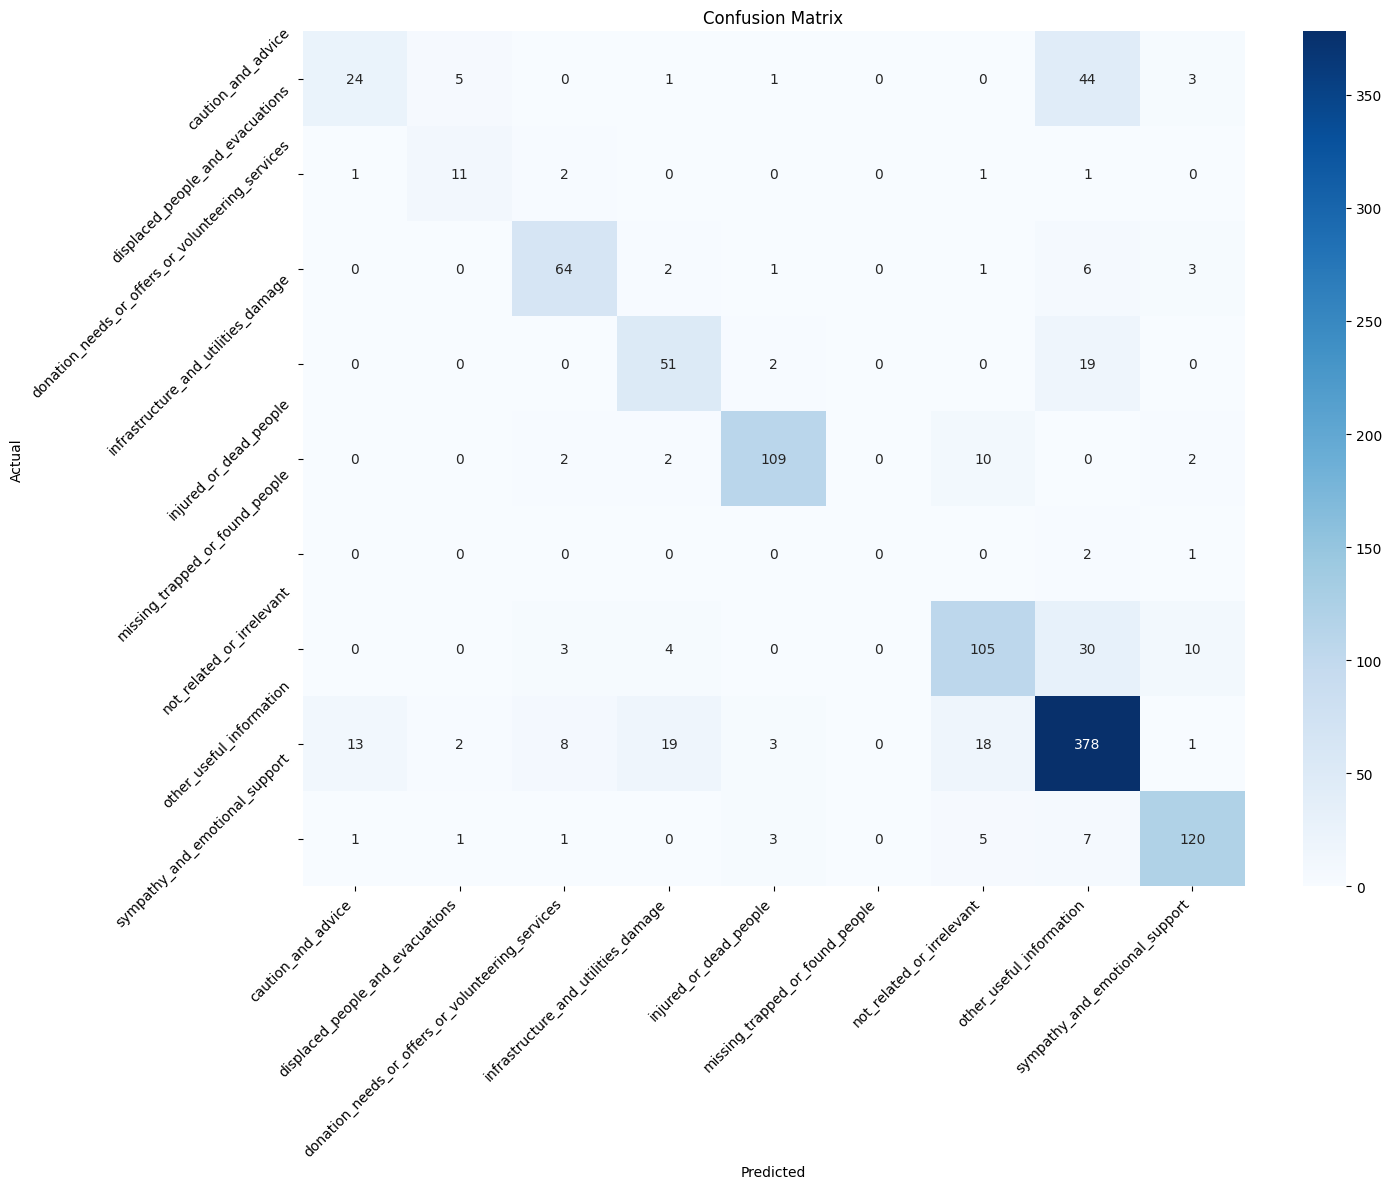


Classification Report:
                                                   precision    recall  f1-score   support

                               caution_and_advice       0.62      0.31      0.41        78
                 displaced_people_and_evacuations       0.58      0.69      0.63        16
donation_needs_or_offers_or_volunteering_services       0.80      0.83      0.82        77
              infrastructure_and_utilities_damage       0.65      0.71      0.68        72
                           injured_or_dead_people       0.92      0.87      0.89       125
                  missing_trapped_or_found_people       0.00      0.00      0.00         3
                        not_related_or_irrelevant       0.75      0.69      0.72       152
                         other_useful_information       0.78      0.86      0.81       442
                   sympathy_and_emotional_support       0.86      0.87      0.86       138

                                         accuracy               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Run the main process
print("Starting main process...")
model = main(eq['tweet_text'].values, eq['label_idx'].values, idx_to_label)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Analyzing lengths:   0%|          | 0/5514 [00:00<?, ?it/s]


Token length statistics:
Mean: 38.0
Median: 38.0
75th percentile: 45.0
90th percentile: 51.0
95th percentile: 54.0
Max: 75


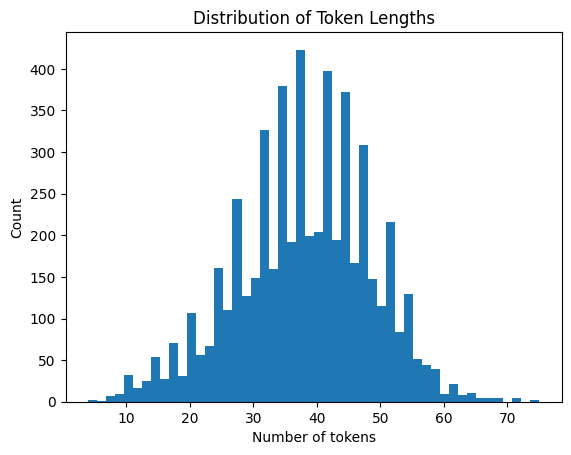

In [ ]:
def analyze_lengths(texts):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Get length of each text after tokenization
    lengths = []
    for text in tqdm(texts, desc="Analyzing lengths"):
        tokens = tokenizer.encode(text, add_special_tokens=True)
        lengths.append(len(tokens))

    print(f"\nToken length statistics:")
    print(f"Mean: {np.mean(lengths):.1f}")
    print(f"Median: {np.median(lengths):.1f}")
    print(f"75th percentile: {np.percentile(lengths, 75):.1f}")
    print(f"90th percentile: {np.percentile(lengths, 90):.1f}")
    print(f"95th percentile: {np.percentile(lengths, 95):.1f}")
    print(f"Max: {max(lengths)}")

    return lengths

# Call the function
lengths = analyze_lengths(eq['tweet_text'].values)

# Optional: visualize distribution
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.title('Distribution of Token Lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Count')
plt.show()

# MAX_LENGTH choose 54